In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

from models.sub_cos_glm import Sub_Cos_GLM
#from models.sub_tcn import Sub_TCN
#from models.gru import GRU
#from models.tcn_multilayer import TCN_Multilayer
#from models.lstm import LSTM
#from models.tcn import TCN
#from models.sub_cos_tcn import Sub_Cos_TCN
#from models.cos_tcn import Cos_TCN
#from models.gru_exp import GRU
#from models.gru_stacked import GRU_Stacked

In [2]:
base_dir = "/scratch/yjk27/"
experiment = "NA_NMDA"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
V_file  = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.6_Ni200_gG0.1_gB0.06_NA1.5_NMDA0.75_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1_set1.npy"
#V_file = "V_diff_stimseed1_set1.npy"
#V_file = "V_diff_NA0.75_NMDA1.5_stimseed1.npy"

#E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
#I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
E_neural = scipy.sparse.load_npz(base_dir+"CA1_clust4-60/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+"CA1_clust4-60/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
V -= torch.mean(V)

"""
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1_set1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1_set1.npy"
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)
"""

#####
#V_test_raw = np.load("/media/hdd01/sklee/"+experiment+"/data/V_diff_stimseed1.npy")
#V_test_raw = torch.from_numpy(V_test_raw)
#V_test_raw -= torch.mean(V_test_raw)

#test_E_neural_raw = scipy.sparse.load_npz("/media/hdd01/sklee/"+experiment+"/data/Espikes_neural.npz")
#test_I_neural_raw = scipy.sparse.load_npz("/media/hdd01/sklee/"+experiment+"/data/Ispikes_neural.npz")
#####

C_syn_e = np.load(base_dir+"CA1_clust4-60"+"/data/handsub5_C_syn_e.npy")
C_syn_i = np.load(base_dir+"CA1_clust4-60"+"/data/handsub5_C_syn_i.npy")
C_syn_e = torch.from_numpy(C_syn_e).float()
C_syn_i = torch.from_numpy(C_syn_i).float()

#C_syn_e = C_syn_e[:,e_idx]
#C_syn_i = C_syn_i[:,i_idx]

In [3]:
T_train = 980 * 1000 * 50
T_test = 1 * 1000 * 50
H_no = 1
sub_no = 5
E_no = 2000
I_no = 200
#E_no = e_idx.shape[0]
#I_no = i_idx.shape[0]
T_no = 500
#T_no = 350
device = torch.device("cuda:2")

#layer_no = 3

increment = 50
batch_length = 50000
batch_size = 5
iter_no = 9800*2
epoch_no = iter_no*batch_length*batch_size//T_train

In [4]:
V_train = V[:T_train].float()
V_test = V[-50000:].to(device).float()

#V_test = V_test_raw[50000*993:50000*994].to(device).float()

test_E_neural = E_neural[-50000:].toarray()
test_I_neural = I_neural[-50000:].toarray()
#test_E_neural = E_neural[50000*993:50000*994].toarray()
#test_I_neural = I_neural[50000*993:50000*994].toarray()
#test_E_neural = test_E_neural_raw[50000*993:50000*994].toarray()
#test_I_neural = test_I_neural_raw[50000*993:50000*994].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
model = Sub_Cos_GLM(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, device)
#model = GRU(C_syn_e.to(device), C_syn_i.to(device), H_no, device)
#model = GRU_Stacked(C_syn_e.to(device), C_syn_i.to(device), H_no, device)
#model = Sub_TCN(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, device)
#model = LSTM(C_syn_e.to(device), C_syn_i.to(device), H_no, device)
#model = TCN(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, layer_no, device)
#model = Sub_Cos_TCN(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, layer_no, device)
#model = Cos_TCN(E_no, I_no, T_no, H_no, layer_no, device)
#model = TCN_Multilayer(T_no-1, 2200, layer_no, H_no, device)

# GLM (1.025 for V_diff, 1 for noNA)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005/(1.035**100))
milestones = np.arange(increment-1, increment*100, increment)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1.035)

# GRU (1 for V_diff, 1 for noNA)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.005/(1**100))
#milestones = np.arange(increment-1, increment*100, increment)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1)

#TCN multilayer
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025,
                             #weight_decay=0.0000001) # for TCNMUlti
                             #weight_decay=0)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

2511


In [6]:
score_list = np.empty((iter_no))

for i in tnrange(iter_no):
#for i in tnrange(12000):
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    V_pred, _, _ = model(batch_E_neural, batch_I_neural)
    #V_pred, _ = model(batch_E_neural[:,5000:35000,e_idx], batch_I_neural[:,5000:35000,i_idx])
    #V_pred = model(batch_E_neural, batch_I_neural)
    
    train_score = explained_variance_score(batch_V[:,:].flatten().cpu().detach().numpy(),
                                           V_pred.flatten().cpu().detach().numpy())
    
    loss = torch.mean((V_pred- batch_V[:,:] )**2)
    loss.backward()
    optimizer.step()
    #scheduler.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred, test_sub_out, _ = model(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0))
        #test_V_pred, test_sub_out = model(test_E_neural.unsqueeze(0)[:,5000:35000,e_idx], test_I_neural.unsqueeze(0)[:,5000:35000,i_idx])
        #test_V_pred = model(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0))
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy()[:], test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test[:]-test_V_pred)**2).item()
        score_list[i//50] = test_score
                
        print(i, np.round(test_score,6),
              np.round(train_score,6))


<ipython-input-6-a1715703122f>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/19600 [00:00<?, ?it/s]

0 0.026599 0.029985
49 0.223783 0.236688
99 0.323462 0.33088
149 0.378149 0.395624
199 0.412872 0.430788
249 0.437762 0.458123
299 0.456387 0.485143
349 0.470936 0.489634
399 0.483522 0.507459
449 0.493551 0.520632
499 0.503364 0.519483
549 0.510665 0.531633
599 0.518706 0.540852
649 0.525153 0.546991
699 0.53195 0.559147
749 0.537485 0.569026
799 0.54343 0.557813
849 0.548293 0.58047
899 0.553519 0.581841
949 0.558651 0.573476
999 0.563603 0.578383
1049 0.567257 0.583889
1099 0.572094 0.603156
1149 0.576219 0.600859
1199 0.580418 0.596016
1249 0.583777 0.599284
1299 0.587257 0.617586
1349 0.591375 0.613809
1399 0.595315 0.620453
1449 0.598203 0.627574
1499 0.60051 0.64837
1549 0.604739 0.638794
1599 0.608158 0.632354
1649 0.611001 0.645465
1699 0.61299 0.646494
1749 0.616252 0.64549
1799 0.619492 0.652665
1849 0.622067 0.651211
1899 0.625594 0.652671
1949 0.627285 0.652599
1999 0.63019 0.653825
2049 0.632402 0.646552
2099 0.634197 0.650296
2149 0.638245 0.668972
2199 0.640008 0.666447

17749 0.921047 0.922279
17799 0.921317 0.921982
17849 0.921449 0.923618
17899 0.921611 0.926668
17949 0.921443 0.924733
17999 0.92175 0.926013
18049 0.921428 0.926941
18099 0.921953 0.922293
18149 0.921712 0.917529
18199 0.921949 0.924561
18249 0.921795 0.925622
18299 0.921904 0.928246
18349 0.921997 0.925196
18399 0.922365 0.922821
18449 0.921937 0.925129
18499 0.922246 0.921929
18549 0.922452 0.917906
18599 0.922424 0.924829
18649 0.9226 0.927923
18699 0.922189 0.927347
18749 0.922653 0.924708
18799 0.922596 0.920036
18849 0.922607 0.920171
18899 0.922656 0.928331
18949 0.92257 0.919591
18999 0.922641 0.927999
19049 0.922828 0.924839
19099 0.923278 0.926673
19149 0.922869 0.920407
19199 0.922819 0.921387
19249 0.923257 0.926656
19299 0.92338 0.924974
19349 0.923215 0.925095
19399 0.923244 0.929328
19449 0.923333 0.92526
19499 0.923331 0.932166
19549 0.923445 0.925605
19599 0.923505 0.92862


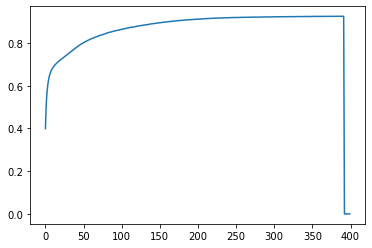

In [9]:
plt.plot(score_list[:400])
#plt.ylim(0,1)

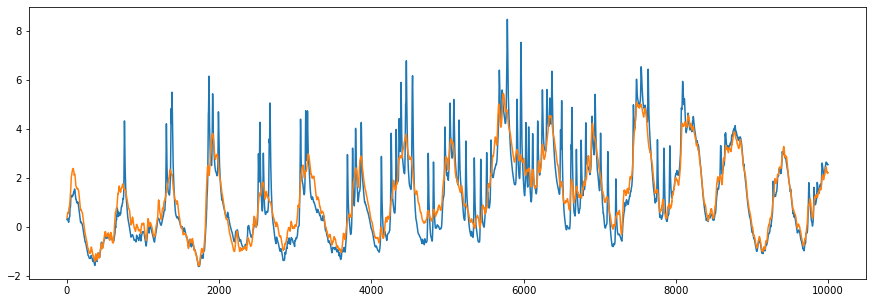

In [7]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[17000:27000])
plt.plot(test_V_pred.cpu().detach().numpy()[17000:27000])

In [7]:
#torch.save(model.state_dict(), "/scratch/yjk27/CA1_NA_NMDA/NA1.5_NMDA0.75/glm_s5_h1.pt")